# Technical Report

## Methodology 

First, I converted the data to pd.df format, assigned words to their parts of speech and divided them into sentences, and also removed empty lines between sentences. Next, I represented the words as a set of features. On such a dataset, we can already train the model. сrf was chosen as the model for the implementation of the task. I used GridSearch to determine the best parameters, but for some reason this did not lead to a positive result. As input, the model receives a list of lists, where inside the list of sentences there are lists of words. Accordingly, at the output, we also get a list of lists, which must be converted to array format to be added to the dataframe. After that I return blank lines between sentences, deal with correct tabs and finish my work.

## Discussion of results

I got these results:

Method | dev_no_ans | test_no_ans
--- | --- | ---
Baseline | 0.433 | 0.535
crf w gs | 0.503 | 0.615
crf w/o gs | 0.493 | 0.64

Here we can see the table of potential word pairs (one after another):


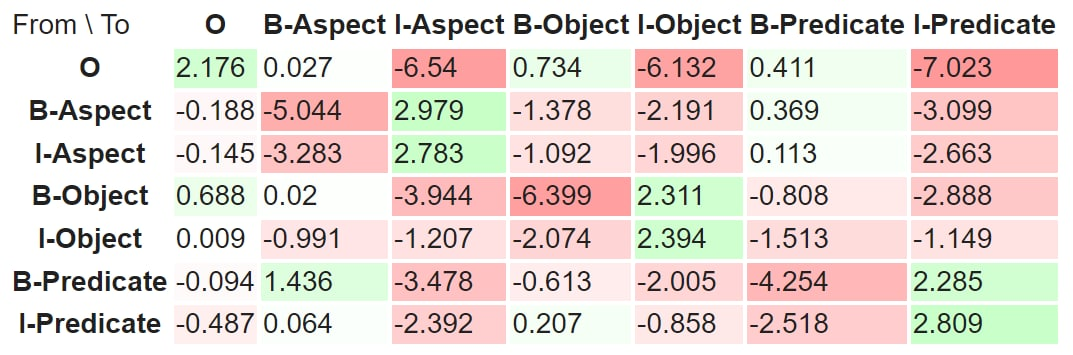

The table looks quite truthful, for example I-predicate is much more likely to come after B/I-predicate, but hardly after any other Tags. 

I also tried to implement the LSTM model, but unfortunately I did not succeed, I wish there was more time)). Also I think it would be a great idea to use different features for words, or vectorize them with BERT and look what happens.

# Code

## Requirements

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 8.7 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.1 MB/s 


In [ ]:
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 7.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

In [ ]:
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 6.8 MB/s 
     |████████████████████████████████| 133 kB 69.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=832c6efc372d0da2c85cab626fda63c03bcb3c5892a157a861a8098aa0a9b7f7
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompa

In [ ]:
import eli5

## Download the data

In [1]:
!wget https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/train.tsv
!wget https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/test_no_answers.tsv
!wget https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/dev_no_answers.tsv

--2022-12-14 15:23:15--  https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599430 (585K) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>] 585.38K  --.-KB/s    in 0.03s   

2022-12-14 15:23:16 (16.5 MB/s) - ‘train.tsv’ saved [599430/599430]

--2022-12-14 15:23:16--  https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/test_no_answers.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58177 (57K) [text/pla

## Preprocessing 

Creating Pandas df with additionall columns Sentence and Part of speech

In [2]:
train = pd.read_csv('train.tsv', lineterminator='\n', sep='\\t', skip_blank_lines=False, names=['Word', 'Tag'])
train = train.applymap(str)
train['Sentence #'] = None
train['POS'] = None

train

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,Word,Tag,Sentence #,POS
0,also,O,None,None
1,",",O,None,None
2,i,O,None,None
3,have,O,None,None
4,recently,O,None,None
...,...,...,...,...
63403,superior,B-Predicate,None,None
63404,to,O,None,None
63405,google,B-Object,None,None
63406,.,O,None,None


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63408 entries, 0 to 63407
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Word        63408 non-null  object
 1   Tag         63408 non-null  object
 2   Sentence #  0 non-null      object
 3   POS         0 non-null      object
dtypes: object(4)
memory usage: 1.9+ MB


Numerating the sentences and adding POS

In [4]:
train['Sentence #'][0] = 'Sentence: ' + str(1)
j = 2
for i in range(train.shape[0]):
  tokens = nltk.word_tokenize(train['Word'][i])
  train['POS'][i] = np.array(nltk.pos_tag(tokens))[0][1]
  if train['Word'][i] == 'nan':
    train['Sentence #'][i+1] = 'Sentence: ' + str(j)
    j+=1

In [5]:
train = train.iloc[:, [2,0,3,1]].copy()

In [6]:
train.isnull().sum()

Sentence #    61074
Word              0
POS               0
Tag               0
dtype: int64

In [7]:
train = train.fillna(method='ffill')
train["Sentence #"] = train["Sentence #"].apply(lambda s: s[9:])
train["Sentence #"] = train["Sentence #"].astype("int32")
train['Sentence #'].nunique(), train['Word'].nunique(), train['Tag'].nunique()

(2334, 6584, 8)

In [8]:
train

,Sentence #,Word,POS,Tag
0,1,also,RB,O
1,1,",",",",O
2,1,i,NN,O
3,1,have,VB,O
4,1,recently,RB,O
...,...,...,...,...
63403,2334,superior,JJ,B-Predicate
63404,2334,to,TO,O
63405,2334,google,NN,B-Object
63406,2334,.,.,O


Deleting nan rows

In [9]:
train_buf = train.copy()
for i in range(train.shape[0]):
  if train['Word'].iloc[i] == 'nan':
    train_buf = train_buf.drop(labels=i, axis=0)

In [10]:
train_buf = train_buf.sort_index().reset_index(drop=True)

train_buf

,Sentence #,Word,POS,Tag
0,1,also,RB,O
1,1,",",",",O
2,1,i,NN,O
3,1,have,VB,O
4,1,recently,RB,O
...,...,...,...,...
61069,2334,consistently,RB,O
61070,2334,superior,JJ,B-Predicate
61071,2334,to,TO,O
61072,2334,google,NN,B-Object


In [11]:
train_buf.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-Aspect,2069
1,B-Object,6174
2,B-Predicate,3109
3,I-Aspect,591
4,I-Object,192
5,I-Predicate,427
6,O,48512


## My method of text processing

## Test

Creating list of sentences

In [13]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = train_buf.groupby("Sentence #").apply(to_tuples).tolist()


In [14]:
print(sentences[-1])

[('in', 'IN', 'O'), ('the', 'DT', 'O'), ('content', 'NN', 'O'), ('of', 'IN', 'O'), ('search', 'NN', 'B-Aspect'), ('results', 'NNS', 'I-Aspect'), (',', ',', 'O'), ('bing', 'NN', 'B-Object'), ('is', 'VBZ', 'O'), ('not', 'RB', 'B-Predicate'), ('consistently', 'RB', 'O'), ('superior', 'JJ', 'B-Predicate'), ('to', 'TO', 'O'), ('google', 'NN', 'B-Object'), ('.', '.', 'O')]


Representing words as a set features

In [15]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2labels(sent):
    return [label for token, postag, label in sent]
def sent2tokens(sent):
    return [token for token, postag, label in sent]

Training the model

In [16]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [17]:
len(X_test)

771

In [18]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.01,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.01,
    keep_tempfiles=None, max_iterations=100)

Results

In [19]:
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

    B-Aspect       0.56      0.36      0.44       719
    B-Object       0.91      0.91      0.91      1993
 B-Predicate       0.91      0.88      0.90      1041
    I-Aspect       0.41      0.18      0.25       202
    I-Object       0.90      0.62      0.74        74
 I-Predicate       0.58      0.37      0.45       147
           O       0.94      0.97      0.96     16223

    accuracy                           0.93     20399
   macro avg       0.74      0.61      0.66     20399
weighted avg       0.92      0.93      0.92     20399



In [20]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.919560913225427

Trying to higher the score by using GridSearch

In [113]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted')

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.0min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f927180fb80>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f92721aeb20>},
                   scoring=make_scorer(flat_f1_score, average=weighted),
                   verbose=1)

In [114]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.23645759713082168, 'c2': 0.0591715068904242}
best CV score: 0.9219978006339256
model size: 0.48M


In [115]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

    B-Aspect       0.60      0.35      0.44       719
    B-Object       0.92      0.92      0.92      1993
 B-Predicate       0.92      0.88      0.90      1041
    I-Aspect       0.43      0.19      0.26       202
    I-Object       0.92      0.61      0.73        74
 I-Predicate       0.63      0.40      0.49       147
           O       0.94      0.97      0.96     16223

    accuracy                           0.93     20399
   macro avg       0.77      0.62      0.67     20399
weighted avg       0.92      0.93      0.92     20399



Not a big difference, moreover on test dataset we will get lower score with GS

In [116]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.922057834243843

Look at probability of different word pairs sequences

In [29]:
eli5.show_weights(crf, top=10)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


## dev_no_answers

Doing the same preprocessng for dev_no_answers

In [117]:
dev_no_answers = pd.read_csv('dev_no_answers.tsv', lineterminator='\n', sep='\\t', engine='python', skip_blank_lines=False, names=['Word', 'Tag'])
dev_no_answers = dev_no_answers.applymap(str)
dev_no_answers['Sentence #'] = np.nan
dev_no_answers['POS'] = np.nan

dev_no_answers

,Word,Tag,Sentence #,POS
0,meanwhile,nan,NaN,NaN
1,",",nan,NaN,NaN
2,though,nan,NaN,NaN
3,windows,nan,NaN,NaN
4,8,nan,NaN,NaN
...,...,...,...,...
8641,",",nan,NaN,NaN
8642,or,nan,NaN,NaN
8643,purse,nan,NaN,NaN
8644,.,nan,NaN,NaN


In [118]:
dev_no_answers['Sentence #'][0] = 'Sentence: ' + str(1)
j = 2
for i in range(dev_no_answers.shape[0]):
  tokens = nltk.word_tokenize(dev_no_answers['Word'][i])
  dev_no_answers['POS'][i] = np.array(nltk.pos_tag(tokens))[0][1]
  if dev_no_answers['Word'][i] == 'nan':
    dev_no_answers['Sentence #'][i+1] = 'Sentence: ' + str(j)
    j+=1

<ipython-input-118-105dd54313e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_no_answers['Sentence #'][0] = 'Sentence: ' + str(1)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-118-105dd54313e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_no_answers['POS'][i] = np.array(nltk.pos_tag(tokens

In [119]:
dev_no_answers = dev_no_answers.iloc[:, [2,0,3,1]].copy()

In [120]:
dev_no_answers

,Sentence #,Word,POS,Tag
0,Sentence: 1,meanwhile,RB,nan
1,NaN,",",",",nan
2,NaN,though,IN,nan
3,NaN,windows,NNS,nan
4,NaN,8,CD,nan
...,...,...,...,...
8641,NaN,",",",",nan
8642,NaN,or,CC,nan
8643,NaN,purse,NN,nan
8644,NaN,.,.,nan


In [121]:
dev_no_answers.isnull().sum()

Sentence #    8363
Word             0
POS              0
Tag              0
dtype: int64

In [122]:
dev_no_answers = dev_no_answers.fillna(method='ffill')
dev_no_answers["Sentence #"] = dev_no_answers["Sentence #"].apply(lambda s: s[9:])
dev_no_answers["Sentence #"] = dev_no_answers["Sentence #"].astype("int32")
dev_no_answers['Sentence #'].nunique(), dev_no_answers['Word'].nunique(), dev_no_answers['Tag'].nunique()

(283, 1840, 1)

In [123]:
dev_no_answers

,Sentence #,Word,POS,Tag
0,1,meanwhile,RB,nan
1,1,",",",",nan
2,1,though,IN,nan
3,1,windows,NNS,nan
4,1,8,CD,nan
...,...,...,...,...
8641,283,",",",",nan
8642,283,or,CC,nan
8643,283,purse,NN,nan
8644,283,.,.,nan


In [124]:
dota = dev_no_answers.copy()
for i in range(dev_no_answers.shape[0]):
  if dev_no_answers['Word'].iloc[i] == 'nan':
    dota = dota.drop(labels=i, axis=0)

In [125]:
dota = dota.sort_index().reset_index(drop=True)
dota

,Sentence #,Word,POS,Tag
0,1,meanwhile,RB,nan
1,1,",",",",nan
2,1,though,IN,nan
3,1,windows,NNS,nan
4,1,8,CD,nan
...,...,...,...,...
8358,283,wallet,NN,nan
8359,283,",",",",nan
8360,283,or,CC,nan
8361,283,purse,NN,nan


In [126]:
sentences_pred = dota.groupby("Sentence #").apply(to_tuples).tolist()

In [127]:
sentences_pred[-1]

[('it', 'PRP', 'nan'),
 ('turns', 'NNS', 'nan'),
 ('out', 'IN', 'nan'),
 ('that', 'IN', 'nan'),
 ('searching', 'VBG', 'nan'),
 ('through', 'IN', 'nan'),
 ('the', 'DT', 'nan'),
 ('digital', 'NN', 'nan'),
 ('contents', 'NNS', 'nan'),
 ('of', 'IN', 'nan'),
 ('a', 'DT', 'nan'),
 ('person', 'NN', 'nan'),
 ("'", "''", 'nan'),
 ('s', 'NN', 'nan'),
 ('mobile', 'NN', 'nan'),
 ('phone', 'NN', 'nan'),
 ('is', 'VBZ', 'nan'),
 ('more', 'RBR', 'nan'),
 ('intrusive', 'JJ', 'nan'),
 ('than', 'IN', 'nan'),
 ('rifling', 'VBG', 'nan'),
 ('through', 'IN', 'nan'),
 ('an', 'DT', 'nan'),
 ('address', 'NN', 'nan'),
 ('book', 'NN', 'nan'),
 (',', ',', 'nan'),
 ('wallet', 'NN', 'nan'),
 (',', ',', 'nan'),
 ('or', 'CC', 'nan'),
 ('purse', 'NN', 'nan'),
 ('.', '.', 'nan')]

In [128]:
test_to_model = [sent2features(s) for s in sentences_pred]

Predicting Tags

In [129]:
y_pred_test = crf.predict(test_to_model)

In [130]:
y_pred_test[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Predicate',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Predicate',
 'O',
 'B-Aspect',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Object',
 'O']

Creating list of tags instead of list of lists

In [131]:
import itertools

ya_ghoul_vec = list(itertools.chain(*y_pred_test))

In [132]:
len(ya_ghoul_vec)

8363

In [133]:
ya_ghoul_vec[8300:8363]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Predicate',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Object',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Predicate',
 'I-Predicate',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [134]:
dota

,Sentence #,Word,POS,Tag
0,1,meanwhile,RB,nan
1,1,",",",",nan
2,1,though,IN,nan
3,1,windows,NNS,nan
4,1,8,CD,nan
...,...,...,...,...
8358,283,wallet,NN,nan
8359,283,",",",",nan
8360,283,or,CC,nan
8361,283,purse,NN,nan


In [135]:
dota2 = dota.copy()

Appending Tags to our df

In [136]:
for i in range(dota2.shape[0]):
  dota2['Tag'].iloc[i] = ya_ghoul_vec[i]

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [137]:
dota2.tail(50)

,Sentence #,Word,POS,Tag
8313,282,go,VB,O
8314,282,-,:,O
8315,282,to,TO,O
8316,282,mobile,NN,O
8317,282,payment,NN,O
8318,282,system,NN,O
8319,282,",",",",O
8320,282,even,RB,O
8321,282,greater,JJR,B-Predicate
8322,282,than,IN,O


In [138]:

data3 = dota2.copy().drop('POS', axis=1)

In [139]:
data3

,Sentence #,Word,Tag
0,1,meanwhile,O
1,1,",",O
2,1,though,O
3,1,windows,O
4,1,8,O
...,...,...,...
8358,283,wallet,O
8359,283,",",O
8360,283,or,O
8361,283,purse,O


In [140]:
data3.sort_index().reset_index(drop=True)

,Sentence #,Word,Tag
0,1,meanwhile,O
1,1,",",O
2,1,though,O
3,1,windows,O
4,1,8,O
...,...,...,...
8358,283,wallet,O
8359,283,",",O
8360,283,or,O
8361,283,purse,O


Adding nan rows back:)

In [141]:
data4 = data3.copy() 
for i in range(data3.shape[0]-1): 
 if data3['Sentence #'].iloc[i] != data3['Sentence #'].iloc[i+1]: 
  k = i + 0.5 
  data4.loc[k] = [ None, None, None]
j = np.int32(data4.shape[0]-1) + 0.5
data4.loc[j] = [None, None, None]

In [142]:
data4 = data4.sort_index().reset_index(drop=True)

In [143]:
data4[146:200]

,Sentence #,Word,Tag
146,5,than,O
147,5,it,O
148,5,',O
149,5,s,O
150,5,been,O
151,5,since,O
152,5,october,O
153,5,2001,O
154,5,",",O
155,5,when,O


In [144]:
data4 = data4.drop('Sentence #', axis=1)

In [153]:
data4.to_csv('Messi.tsv', sep='\t', index=False, header=False, line_terminator='\n')

In [154]:
data4.shape

(8646, 2)

In [155]:
delta = pd.read_csv('Messi.tsv', sep='\t', engine='python')
delta

,meanwhile,O
0,",",O
1,though,O
2,windows,O
3,8,O
4,is,O
...,...,...
8640,",",O
8641,or,O
8642,purse,O
8643,.,O


Unfortunately instead of empty row we have \t there, so that's how we fix the problem

In [157]:
to_fix = list(open('Messi.tsv'))

In [158]:
for i in range(len(to_fix)):
  if to_fix[i] == '\t\n':
    to_fix[i] = '\n'

In [159]:
import csv

In [160]:
with open('Ancara_Messi.tsv', 'w') as file:
  file.write(''.join(to_fix))

In [161]:
!zip 'Messi_will_win_WC_2022.zip' 'Ancara_Messi.tsv'

  adding: Ancara_Messi.tsv (deflated 73%)


## Test_no_answers

Doing absolutely the same things as with dev_no_ans.

In [162]:
test_no_answers = pd.read_csv('test_no_answers.tsv', lineterminator='\n', sep='\\t', engine='python', skip_blank_lines=False, names=['Word', 'Tag'])
test_no_answers = test_no_answers.applymap(str)
test_no_answers['Sentence #'] = np.nan
test_no_answers['POS'] = np.nan

test_no_answers

,Word,Tag,Sentence #,POS
0,plus,nan,NaN,NaN
1,",",nan,NaN,NaN
2,android,nan,NaN,NaN
3,is,nan,NaN,NaN
4,developing,nan,NaN,NaN
...,...,...,...,...
9799,steal,nan,NaN,NaN
9800,its,nan,NaN,NaN
9801,thunder,nan,NaN,NaN
9802,.,nan,NaN,NaN


In [163]:
test_no_answers['Sentence #'][0] = 'Sentence: ' + str(1)
j = 2
for i in range(test_no_answers.shape[0]):
  tokens = nltk.word_tokenize(test_no_answers['Word'][i])
  test_no_answers['POS'][i] = np.array(nltk.pos_tag(tokens))[0][1]
  if test_no_answers['Word'][i] == 'nan':
    test_no_answers['Sentence #'][i+1] = 'Sentence: ' + str(j)
    j+=1

<ipython-input-163-13b960a312d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_no_answers['Sentence #'][0] = 'Sentence: ' + str(1)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-163-13b960a312d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_no_answers['POS'][i] = np.array(nltk.pos_tag(toke

In [164]:
test_no_answers = test_no_answers.iloc[:, [2,0,3,1]].copy()

In [165]:
test_no_answers.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,plus,CC,nan
1,NaN,",",",",nan
2,NaN,android,NN,nan
3,NaN,is,VBZ,nan
4,NaN,developing,VBG,nan
5,NaN,a,DT,nan
6,NaN,way,NN,nan
7,NaN,faster,NN,nan
8,NaN,than,IN,nan
9,NaN,ios,NNS,nan


In [166]:
test_no_answers.isnull().sum()

Sentence #    9444
Word             0
POS              0
Tag              0
dtype: int64

In [167]:
test_no_answers = test_no_answers.fillna(method='ffill')
test_no_answers["Sentence #"] = test_no_answers["Sentence #"].apply(lambda s: s[9:])
test_no_answers["Sentence #"] = test_no_answers["Sentence #"].astype("int32")
test_no_answers['Sentence #'].nunique(), test_no_answers['Word'].nunique(), test_no_answers['Tag'].nunique()

(360, 1961, 1)

In [168]:
test_no_answers

,Sentence #,Word,POS,Tag
0,1,plus,CC,nan
1,1,",",",",nan
2,1,android,NN,nan
3,1,is,VBZ,nan
4,1,developing,VBG,nan
...,...,...,...,...
9799,360,steal,NN,nan
9800,360,its,PRP$,nan
9801,360,thunder,NN,nan
9802,360,.,.,nan


In [169]:
dita = test_no_answers.copy()
for i in range(test_no_answers.shape[0]):
  if test_no_answers['Word'].iloc[i] == 'nan':
    dita = dita.drop(labels=i, axis=0)

In [170]:
dita = dita.sort_index().reset_index(drop=True)
dita

,Sentence #,Word,POS,Tag
0,1,plus,CC,nan
1,1,",",",",nan
2,1,android,NN,nan
3,1,is,VBZ,nan
4,1,developing,VBG,nan
...,...,...,...,...
9439,360,and,CC,nan
9440,360,steal,NN,nan
9441,360,its,PRP$,nan
9442,360,thunder,NN,nan


In [171]:
sentences_gg = dita.groupby("Sentence #").apply(to_tuples).tolist()

In [172]:
sentences_gg[-1]

[('design', 'NN', 'nan'),
 ('toshiba', 'NN', 'nan'),
 ('makes', 'VBZ', 'nan'),
 ('much', 'JJ', 'nan'),
 ('of', 'IN', 'nan'),
 ('the', 'DT', 'nan'),
 ('at200', 'NN', 'nan'),
 ("'", "''", 'nan'),
 ('s', 'NN', 'nan'),
 ('thinness', 'NN', 'nan'),
 (',', ',', 'nan'),
 ('and', 'CC', 'nan'),
 ('rightly', 'RB', 'nan'),
 ('so', 'RB', 'nan'),
 (':', ':', 'nan'),
 ('at', 'IN', 'nan'),
 ('7', 'CD', 'nan'),
 ('.', '.', 'nan'),
 ('7mm', 'CD', 'nan'),
 ('it', 'PRP', 'nan'),
 ("'", "''", 'nan'),
 ('s', 'NN', 'nan'),
 ('slimmer', 'NN', 'nan'),
 ('than', 'IN', 'nan'),
 ('the', 'DT', 'nan'),
 ('samsung', 'NN', 'nan'),
 ('galaxy', 'NN', 'nan'),
 ('tab', 'NN', 'nan'),
 ('10', 'CD', 'nan'),
 ('.', '.', 'nan'),
 ('1', 'CD', 'nan'),
 ('(', '(', 'nan'),
 ('8', 'CD', 'nan'),
 ('.', '.', 'nan'),
 ('6mm', 'CD', 'nan'),
 (')', ')', 'nan'),
 ('and', 'CC', 'nan'),
 ('the', 'DT', 'nan'),
 ("'", "''", 'nan'),
 ('new', 'JJ', 'nan'),
 ("'", "''", 'nan'),
 ('ipad', 'NN', 'nan'),
 ('(', '(', 'nan'),
 ('9', 'CD', 'nan'),
 

In [173]:
test_to_model_gg = [sent2features(s) for s in sentences_gg]

In [174]:
y_pred_test_gg = crf.predict(test_to_model_gg)

In [175]:
len(y_pred_test_gg[0])

23

In [176]:
import itertools

ya_ghoul_vec_gg = list(itertools.chain(*y_pred_test_gg))

In [177]:
len(ya_ghoul_vec_gg)

9444

In [178]:
ya_ghoul_vec[8300:8363]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Predicate',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Object',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Predicate',
 'I-Predicate',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [179]:
dita

,Sentence #,Word,POS,Tag
0,1,plus,CC,nan
1,1,",",",",nan
2,1,android,NN,nan
3,1,is,VBZ,nan
4,1,developing,VBG,nan
...,...,...,...,...
9439,360,and,CC,nan
9440,360,steal,NN,nan
9441,360,its,PRP$,nan
9442,360,thunder,NN,nan


In [180]:
dita2 = dita.copy()

In [181]:
for i in range(dita2.shape[0]):
  dita2['Tag'].iloc[i] = ya_ghoul_vec_gg[i]

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [182]:
dita2['Tag'].nunique()

7

In [183]:
dita2.tail(50)

,Sentence #,Word,POS,Tag
9394,360,at,IN,O
9395,360,7,CD,O
9396,360,.,.,O
9397,360,7mm,CD,O
9398,360,it,PRP,O
9399,360,','',O
9400,360,s,NN,O
9401,360,slimmer,NN,O
9402,360,than,IN,O
9403,360,the,DT,O


In [184]:

dita3 = dita2.copy().drop('POS', axis=1)

In [185]:
dita3

,Sentence #,Word,Tag
0,1,plus,O
1,1,",",O
2,1,android,O
3,1,is,O
4,1,developing,O
...,...,...,...
9439,360,and,O
9440,360,steal,O
9441,360,its,O
9442,360,thunder,O


In [186]:
dita3.sort_index().reset_index(drop=True)

,Sentence #,Word,Tag
0,1,plus,O
1,1,",",O
2,1,android,O
3,1,is,O
4,1,developing,O
...,...,...,...
9439,360,and,O
9440,360,steal,O
9441,360,its,O
9442,360,thunder,O


In [201]:
dita4 = dita3.copy() 
for i in range(dita3.shape[0]-1): 
 if dita3['Sentence #'].iloc[i] != dita3['Sentence #'].iloc[i+1]: 
  k = i + 0.5 
  dita4.loc[k] = [ None, None, None]
j = np.int32(dita4.shape[0]-1) + 0.5
dita4.loc[j] = [None, None, None]

In [202]:
dita4 = dita4.sort_index().reset_index(drop=True)

In [203]:
dita4[0:50]

,Sentence #,Word,Tag
0,1,plus,O
1,1,",",O
2,1,android,O
3,1,is,O
4,1,developing,O
5,1,a,O
6,1,way,O
7,1,faster,B-Predicate
8,1,than,O
9,1,ios,O


In [204]:
dita4 = dita4.drop('Sentence #', axis=1)

In [205]:
dita4.to_csv('Messi10.tsv', sep='\t', index=False, header=False, line_terminator='\n')

In [206]:
dita4.shape

(9804, 2)

In [207]:
delta = pd.read_csv('Messi10.tsv', sep='\t', engine='python')
delta

,plus,O
0,",",O
1,android,O
2,is,O
3,developing,O
4,a,O
...,...,...
9798,steal,O
9799,its,O
9800,thunder,O
9801,.,O


In [208]:
to_fix = list(open('Messi10.tsv'))

In [209]:
for i in range(len(to_fix)):
  if to_fix[i] == '\t\n':
    to_fix[i] = '\n'

In [210]:
import csv

In [211]:
with open('Messi_GOAT.tsv', 'w') as file:
  file.write(''.join(to_fix))

In [212]:
!zip 'Messi_Surely_will_win_WC_2022.zip' 'Messi_GOAT.tsv'

  adding: Messi_GOAT.tsv (deflated 74%)
